# Semantic Segmentation

Semantic segmentation is a computer vision task in which every pixel of a given image frame is classified/labelled based on whichever class it belongs to. Typically, Convolutional Neural Networks (CNNs) are used for image segmentation tasks. 

Some standard CNNs used for segmentation tasks are VGG, ResNet, U-Net, AlexNet, etc. In this text-based tutorial, we will be using the architecture of U-Net to perform multi-class segmentation on the Cityscapes dataset. Without any further ado, let us get straight into it.

## Neural Network Architecture

As mentioned above, the neural network that will be used is the U-Net. U-Net was first proposed in [1] for Biomedical Image Segmentation. One of the main advantages of using U-Net is its ability to yield relatively good results on pixel-labelling tasks with limited dataset images.

<img src = 'https://miro.medium.com/max/1400/1*0IaZQvDNAdf1LFqfygZtrQ.png'>

The above image describes the architecture of U-Net. But the architecture used is not entirely similar to one proposed in [1]. The only change is that I’ve used 2D-BatchNorm layers after each of the 3x3 double convolutions. Batch Normalization was first introduced in [2] and showed that normalizing the data sent to a layer improved results. So adding a batch normalization layer will only help improve the performance of the U-Net. Also, a padding of 1 has been used in order to preserve the original dimensions of the input image.

In [ ]:
import torch
from torch import nn

In [ ]:
def double_conv(in_channel, out_channel):
  conv = nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(num_features=out_channel),
      nn.Conv2d(out_channel, out_channel, kernel_size=2, stride=1, padding=1),
      nn.ReLU()
  )
  return conv

def crop_image(tensor, tensor_target):
  target_size = tensor_target.size()[2]
  tensor_size = tensor.size()[2]
  delta = tensor_size-target_size
  delta = delta//2
  return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]

In [ ]:
class UNet(nn.Module):
  def __init__(self, n_class):
    super(UNet, self).__init__()
    self.n_class = n_class
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride =2) #inisialisasi

    self.down_conv1 = double_conv(1,64)
    self.down_conv2 = double_conv(64,128)
    self.down_conv3 = double_conv(128,256)
    self.down_conv4 = double_conv(256,512)
    self.down_conv5 = double_conv(512,1024)

    self.up_trans_1 = nn.ConvTranspose2d(
        in_channels=1024,
        out_channels=512, kernel_size=2, stride=2, padding=1, output_padding=1
    )
    self.up_conv1 = double_conv(1024,512)

    self.up_trans_2 = nn.ConvTranspose2d(
        in_channels=512,
        out_channels=256, kernel_size=2, stride=2, padding=1, output_padding=1
    )
    self.up_conv2 = double_conv(512,256)

    self.up_trans_3 = nn.ConvTranspose2d(
        in_channels=256,
        out_channels=128, kernel_size=2, stride=2, padding=1, output_padding=1
    )
    self.up_conv3 = double_conv(256,128)

    self.up_trans_4 = nn.ConvTranspose2d(
        in_channels=128,
        out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1
    )
    self.up_conv4 = double_conv(128,64)
    self.output = nn.Conv2d(in_channels=64, out_channels=n_class, kernel_size=2, stride=1, padding=1)

  def forward(self, image):
    #encoder step
    x1=self.down_conv1(image)
    x2=self.max_pool_2x2(x1)
    
    x3=self.down_conv2(x2)
    x4=self.max_pool_2x2(x3)
    
    x5=self.down_conv3(x4)
    x6=self.max_pool_2x2(x5)
    x7=self.down_conv4(x6)
    x8=self.max_pool_2x2(x7)
    x9=self.down_conv5(x8)

    #decoder
    x = self.up_trans_1(x9)
    y = crop_image(x7,x)
    x = self.up_conv1(torch.cat((x,y),dim = 1))

    x = self.up_trans_2(x)
    y = crop_image(x5,x)
    #print(x5.shape, x.shape,y.shape)
    x = self.up_conv2(torch.cat((x,y),dim = 1))

    x = self.up_trans_3(x)
    y = crop_image(x3,x)
    x = self.up_conv3(torch.cat((x,y),dim = 1))

    x = self.up_trans_4(x)
    y = crop_image(x1,x)
    x = self.up_conv4(torch.cat((x,y),dim = 1))

    x = self.output(x)
    return x 

In [ ]:
image = torch.rand((1,1,572, 572))
model = UNet(n_class=2)
#model = UNet(num_classes=2)
model(image)

tensor([[[[-0.0540, -0.2527, -0.0834,  ..., -0.1927, -0.1911, -0.1632],
          [-0.0056,  0.0043, -0.0415,  ..., -0.1412,  0.1779,  0.1332],
          [-0.0703,  0.0280, -0.0434,  ..., -0.2327,  0.0352, -0.0236],
          ...,
          [-0.1177,  0.0063, -0.3255,  ..., -0.0186,  0.0005,  0.0470],
          [-0.1307,  0.0402,  0.0413,  ..., -0.0673, -0.0898,  0.1189],
          [ 0.0281,  0.1538, -0.1948,  ..., -0.0090,  0.0231, -0.0256]],

         [[-0.1028, -0.3037, -0.2088,  ..., -0.2356, -0.2272,  0.0051],
          [-0.1196,  0.0259, -0.0163,  ...,  0.1648,  0.1554,  0.0072],
          [-0.0983, -0.2875, -0.0509,  ..., -0.2062,  0.3523, -0.0429],
          ...,
          [-0.1543,  0.1186, -0.0703,  ..., -0.1180, -0.0258, -0.0733],
          [-0.1130,  0.0363, -0.0292,  ..., -0.0834, -0.1846,  0.0376],
          [ 0.1102, -0.1294, -0.1711,  ..., -0.0684, -0.0280, -0.0238]]],


        [[[-0.0962, -0.1908, -0.0781,  ..., -0.5081, -0.1923, -0.1413],
          [-0.0159, -0.1607,

## What is an encoder decoder model?
The best way to understand the concept of an encoder-decoder model is by playing Pictionary. The rules of the game are very simple, player 1 randomly picks a word from a list and needs to sketch the meaning in a drawing. The role of the second player in the team is to analyse the drawing and identify the word which it describes. In this example we have three important elements player 1(the person that converts the word into a drawing), the drawing (rabbit) and the person that guesses the word the drawing represents (player 2). This is all we need to understand an encoder decoder model.

<img src = 'https://miro.medium.com/max/828/1*tdM9YctiX43_9CluSK_aJw.jpeg'>

#### 1-Encoder (Picturist)
Encoding means to convert data into a required format. In the Pictionary example we convert a word (text) into a drawing (image).

#### 2-Hidden State (Sketch)
The output of the encoder, a two-dimensional vector that encapsulates the whole meaning of the input sequence.

#### 3-Decoder
To decode means to convert a coded message into intelligible language. The second person in the team playing Pictionary will convert the drawing into a word. 

## Kaggle Dataset

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d dansbecker/cityscapes-image-pairs

100% 201M/202M [00:05<00:00, 48.5MB/s]
100% 202M/202M [00:05<00:00, 41.8MB/s]


In [ ]:
!unzip cityscapes-image-pairs.zip

Streaming output truncated to the last 5000 lines.
  inflating: cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2767.jpg  
  inflating: citysca

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [ ]:
train_dir = "cityscapes_data/cityscapes_data/train"
val_dir = "cityscapes_data/cityscapes_data/val"
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


cityscapes_data/cityscapes_data/train/2362.jpg


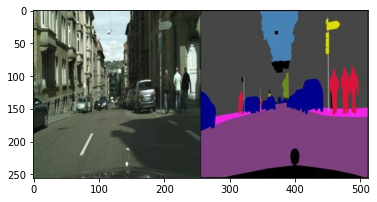

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [ ]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


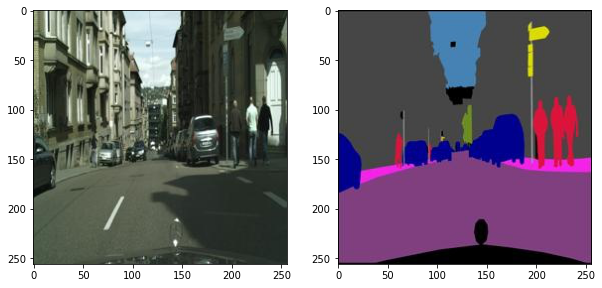

In [ ]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [ ]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[223 220 139]
 [ 41 141 113]
 [160 197 234]
 [ 40 238  80]
 [246 178 238]]


In [ ]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [ ]:
label_model.predict(color_array[:5, :])

array([1, 9, 1, 0, 1], dtype=int32)

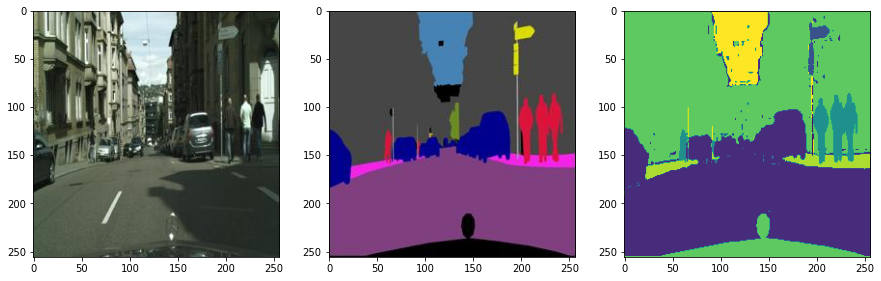

In [ ]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [ ]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [ ]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [ ]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [ ]:
model = UNet(num_classes=num_classes)

In [ ]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [ ]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 257, 257])


In [ ]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [ ]:
batch_size = 16

epochs = 10
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [ ]:
model = UNet(num_classes=num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

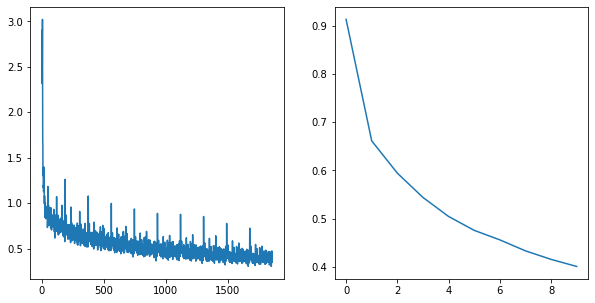

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [ ]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

In [ ]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [ ]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

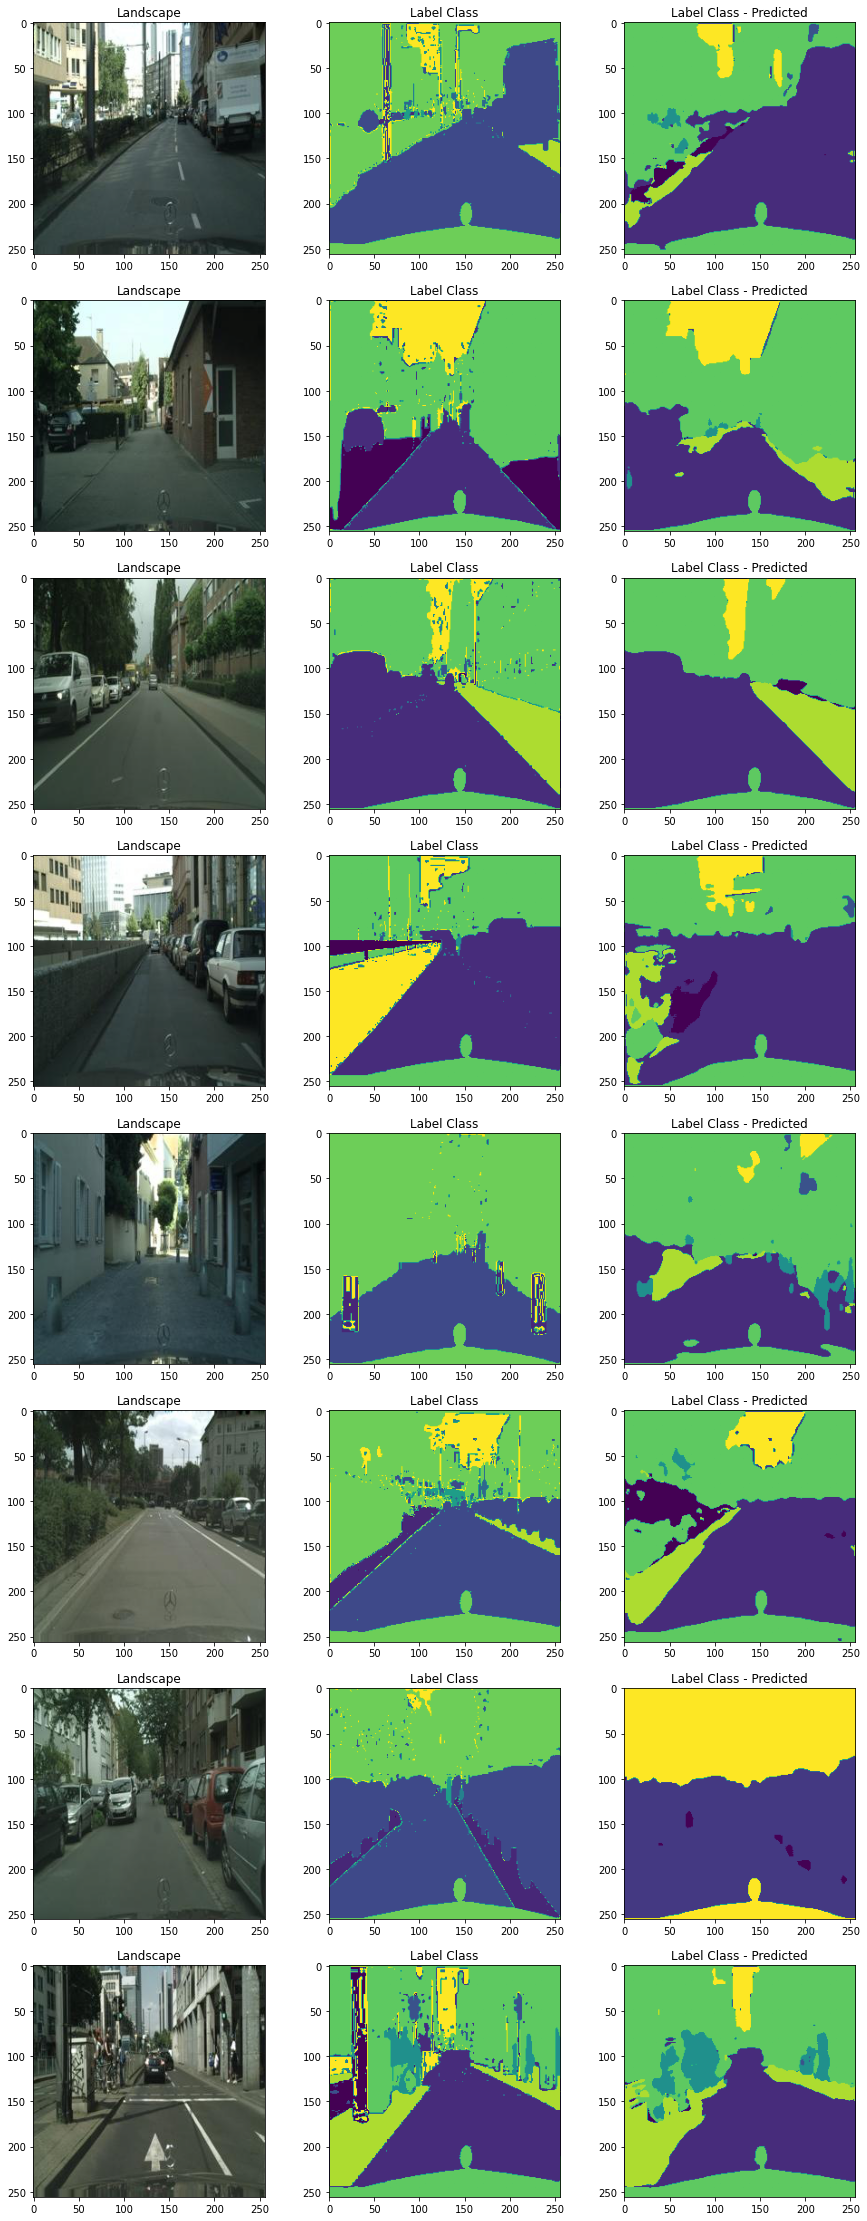

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

References:

[1 Image Segmentation with UNET Pytorch](https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch)
